# Molecular Hydrogen (H2) Exemplar
## Step 0: Import various libraries

In [1]:
# Imports for QSCOUT
import jaqalpaq
from jaqalpaq.core import circuitbuilder
from jaqalpaq.core.circuit import normalize_native_gates
from jaqalpaq import emulator
from qscout.v1 import native_gates

# Imports for basic mathematical functionality
from math import pi
import numpy as np

# Imports for OpenFermion(-PySCF)
import openfermion as of
from openfermion.hamiltonians import MolecularData
from openfermionpyscf import run_pyscf

# Import for VQE optimizer
from scipy import optimize

## Step 1: SCF calculation to assemble the second-quantized Hamiltonian

In [2]:
# Set the basis set, spin, and charge of the H2 molecule
basis = 'sto-3g'
multiplicity = 1
charge = 0

# Set calculation parameters
run_scf = 1
run_fci = 1
delete_input = True
delete_output = False

# Generate molecule at some bond length (0.7474 Angstroms here)
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.7474))]
molecule = MolecularData(
    geometry, basis, multiplicity, charge,    
    filename='./H2_sto-3g_single_0.7474') #Set file location of data

# Run pyscf to generate new molecular data for sto-3g H2
molecule = run_pyscf(molecule,
                     run_scf=run_scf,
                     run_fci=run_fci,
                     verbose=False)

print("Bond Length in Angstroms: {}".format(0.7474))
print("FCI (Exact) energy in Hartrees: {}".format(molecule.fci_energy))

Bond Length in Angstroms: 0.7474
FCI (Exact) energy in Hartrees: -1.137175710240685


## Step 2: Convert the fermionic Hamiltonian to a qubit Hamiltonian

In [3]:
# Get the fermionic Hamiltonian for H2 and map it using the BK encoding
hamiltonian = molecule.get_molecular_hamiltonian()
hamiltonian_ferm = of.get_fermion_operator(hamiltonian)
hamiltonian_bk = of.bravyi_kitaev(hamiltonian_ferm)

# Define Pauli strings that appear in the reduced two-qubit Hamiltonian
terms = [[None, None], [None, 'Z'], ['Z', None], ['Z', 'Z'], ['X', 'X'], ['Y', 'Y']]

# Calculate effective coefficients for the reduced two-qubit Hamiltonian
# Derivation follows arXiv:1803.10238v2 appendix A-2
fs = hamiltonian_bk.terms #Old coefficients from OpenFermion Hamiltonian
c0 = (fs[()] + fs[(1, 'Z'),] + fs[(1, 'Z'), (3, 'Z'),]).real
c1 = (fs[(0, 'Z'),] + fs[(0, 'Z'), (1, 'Z'),]).real
c2 = (fs[(2, 'Z'),] + fs[(1, 'Z'), (2, 'Z'), (3, 'Z'),]).real
c3 = (fs[(0, 'Z'), (2, 'Z'),] + fs[(0, 'Z'), (1, 'Z'), (2, 'Z'),] + fs[(0, 'Z'), (2, 'Z'), (3, 'Z'),] + fs[(0, 'Z'), (1, 'Z'), (2, 'Z'), (3, 'Z')]).real
c4 = (fs[(0,'X'), (1, 'Z'), (2, 'X'),] + fs[(0, 'X'), (1, 'Z'), (2, 'X'), (3, 'Z'),]).real
c5 = (fs[(0, 'Y'), (1, 'Z'), (2, 'Y'),] + fs[(0, 'Y'), (1, 'Z'), (2, 'Y'), (3, 'Z'),]).real
cs = [c0, c1, c2, c3, c4, c5] #New coefficients are linear combinations of old coefficients

# Number of times to sample from measurement circuits
n_samples = 10000

## Step 3: Define UCC Ansatz circuit in JaqalPaq

In [4]:
def ansatz(theta, sample_noise=False):
    term_probs = []
    for i in range(len(terms)):
        builder = circuitbuilder.CircuitBuilder(native_gates=normalize_native_gates(native_gates.NATIVE_GATES))
        
        # Define constants +-pi/2
        pi2 = builder.let('pi2', pi/2)
        npi2 = builder.let('npi2', -pi/2)
        
        # Create a qubit register
        q = builder.register('q', 2)
        
        # Define a hadamard macro
        hadamard = circuitbuilder.SequentialBlockBuilder()
        hadamard.gate('Sy', 'a')
        hadamard.gate('Px', 'a')
        builder.macro('hadamard', ['a'], hadamard)
        
        # Prepare the Hartree Fock state
        builder.gate('prepare_all')
        builder.gate('Px', q[0])
        
        # Apply the UCC Ansatz exp[-i*theta(X1 Y0)]
        builder.gate('MS', q[1], q[0], 0, pi2)
        builder.gate('Rz', q[1], theta)
        builder.gate('MS', q[1], q[0], 0, npi2)
        
        # Change basis for measurement depending on term
        for j, qubit in enumerate(terms[i]):
            if qubit == 'X':
                builder.gate('hadamard', ('array_item', q, j)),
            if qubit == 'Y':
                builder.gate('Sxd', ('array_item', q, j)),
        builder.gate('measure_all')
       
        circuit = builder.build()

        # Format results of simulation as a list of lists
        probs = np.zeros(4) # Number of possible states
        sim_result = emulator.run_jaqal_circuit(circuit) #Run circuit on emulator
        sim_probs = sim_result.subcircuits[0].probability_by_int
        if sample_noise: #Sample circuits to determine probs
            for k in range(n_samples):
                sample = np.random.choice(4, p=sim_probs)
                probs[sample] += 1 #Increment state counter
            probs = probs/n_samples #Determine probabilities from sampling
            term_probs += [probs] #Combine lists of probs of each term in Hamiltonian
        else: #Exact solution without sampling
            term_probs += [sim_probs]
    return term_probs

## Step 4: Define functions to calculate energy expectation value of Ansatz state

In [14]:
# Calculate energy of one term of the Hamiltonian for one possible state
def term_energy(term, state, coefficient, prob):
    parity = 1
    for i in range(len(term)):
        #Change parity if state is occupied and is acted on by a pauli operator
        if term[i] != None and state[i] == '1':
            parity = -1*parity
    return coefficient*prob*parity

# Calculate energy of the molecule for a given value of theta
def make_calculate_energy(sample_noise=False):
    def calculate_energy(theta):
        energy = 0
        probs = ansatz(theta[0], sample_noise) #Convert tuple (from optimization) to float for circuit
        for i in range(len(terms)): #For each term in the hamiltonian
            for j in range(len(probs[0])): #For each possible state
                term = terms[i]
                state = '{0:02b}'.format(j)[::-1] #convert state to binary (# of qubits)
                coefficient = cs[i].real
                prob = probs[i][j]
                #print(term, state, coefficient, prob)
                energy += term_energy(term, state, coefficient, prob)
        return energy
    return calculate_energy

## Step 5: Minimize the energy expectation value in  𝜃

In [8]:
# Minimize the energy using classical optimization
optimize.minimize(fun=make_calculate_energy(sample_noise=True), x0=[0.01], method="COBYLA") #Can use "L-BFGS-B" instead

     fun: -1.137175702877501
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 24
  status: 1
 success: True
       x: array([3.37005156])

## Step 6: Loop over previous steps to calculate ground state energy at different bond lengths

In [18]:
# Set the basis set, spin, and charge of the H2 molecule
basis = 'sto-3g'
multiplicity = 1
charge = 0

# Set calculation parameters
run_scf = 1
run_fci = 1
delete_input = True
delete_output = False

optimized_energies = [[], []]
exact_energies = []

# Number of times to sample from measurement circuits
n_samples = 10000

# Loop over bond lengths from 0.3 to 1.3 angstroms
n_samples = 100 # Sample circuit
n_pts = 11 # Number of points
bond_lengths = np.linspace(0.3,1.3,n_pts)
for diatomic_bond_length in bond_lengths:
    # Generate molecule at some bond length
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity, charge,
        description=str(round(diatomic_bond_length, 2)),
        filename='./H2_sto-3g_single_dissociation')

    # Run pyscf to generate new molecular data for sto-3g H2
    molecule = run_pyscf(molecule,
                     run_scf=run_scf,
                     run_fci=run_fci,
                     verbose=False)
    
    # Get the fermionic Hamiltonian for H2 and map it into qubits using the BK encoding
    hamiltonian = molecule.get_molecular_hamiltonian()
    hamiltonian_ferm = of.get_fermion_operator(hamiltonian)
    hamiltonian_bk = of.bravyi_kitaev(hamiltonian_ferm)

    # Define Pauli strings that appear in the reduced two-qubit Hamiltonian
    terms = [[None, None], [None, 'Z'], ['Z', None], ['Z', 'Z'], ['X', 'X'], ['Y', 'Y']]

    # Calculate effective coefficients for the reduced two-qubit Hamiltonian
    # Derivation follows arXiv:1803.10238v2 appendix A-2
    fs = hamiltonian_bk.terms #Old coefficients from OpenFermion Hamiltonian
    c0 = (fs[()] + fs[(1, 'Z'),] + fs[(1, 'Z'), (3, 'Z'),]).real
    c1 = (fs[(0, 'Z'),] + fs[(0, 'Z'), (1, 'Z'),]).real
    c2 = (fs[(2, 'Z'),] + fs[(1, 'Z'), (2, 'Z'), (3, 'Z'),]).real
    c3 = (fs[(0, 'Z'), (2, 'Z'),] + fs[(0, 'Z'), (1, 'Z'), (2, 'Z'),] + fs[(0, 'Z'), (2, 'Z'), (3, 'Z'),] + fs[(0, 'Z'), (1, 'Z'), (2, 'Z'), (3, 'Z')]).real
    c4 = (fs[(0,'X'), (1, 'Z'), (2, 'X'),] + fs[(0, 'X'), (1, 'Z'), (2, 'X'), (3, 'Z'),]).real
    c5 = (fs[(0, 'Y'), (1, 'Z'), (2, 'Y'),] + fs[(0, 'Y'), (1, 'Z'), (2, 'Y'), (3, 'Z'),]).real
    cs = [c0, c1, c2, c3, c4, c5] #New coefficients are linear combinations of old coefficients

    # Minimize the expectation value of the energy using a classical optimizer (COBYLA)
    exact_energies.append(molecule.fci_energy)
    for i in range(2):
        result = optimize.minimize(fun=make_calculate_energy(sample_noise=i), x0=[0.01], method="COBYLA")
        optimized_energies[i].append(result.fun)
        print("R={}\t Optimized Energy: {}\t Sampling Noise: {}".format(str(round(diatomic_bond_length, 2)), result.fun, bool(i)))

R=0.3	 Optimized Energy: -0.6018037072958554	 Sampling Noise: False
R=0.3	 Optimized Energy: -0.6011701339275781	 Sampling Noise: True
R=0.4	 Optimized Energy: -0.914149691013206	 Sampling Noise: False
R=0.4	 Optimized Energy: -0.8813292348003802	 Sampling Noise: True
R=0.5	 Optimized Energy: -1.0551597871760268	 Sampling Noise: False
R=0.5	 Optimized Energy: -1.0177980744453996	 Sampling Noise: True
R=0.6	 Optimized Energy: -1.1162860002510868	 Sampling Noise: False
R=0.6	 Optimized Energy: -1.1188871880277702	 Sampling Noise: True
R=0.7	 Optimized Energy: -1.136189451219935	 Sampling Noise: False
R=0.7	 Optimized Energy: -1.117400543046679	 Sampling Noise: True
R=0.8	 Optimized Energy: -1.134147660887728	 Sampling Noise: False
R=0.8	 Optimized Energy: -1.1421595065309522	 Sampling Noise: True
R=0.9	 Optimized Energy: -1.1205602768208802	 Sampling Noise: False
R=0.9	 Optimized Energy: -1.090263200629696	 Sampling Noise: True
R=1.0	 Optimized Energy: -1.1011503293270284	 Sampling Noise

## Step 7: Plot the dissociation curve

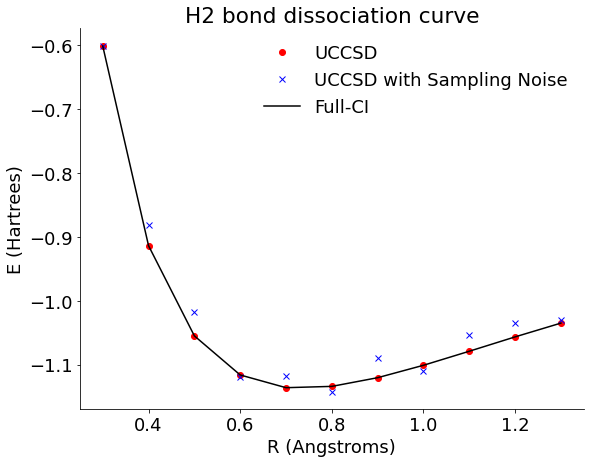

In [21]:
import matplotlib
import matplotlib.pyplot as pyplot

# Plot the various energies for different bond lengths
fig = pyplot.figure(figsize=(10,7))
pyplot.rcParams['font.size']=18
bkcolor = '#ffffff'
ax = fig.add_subplot(1, 1, 1)
pyplot.subplots_adjust(left=.2)
ax.set_xlabel('R (Angstroms)')
ax.set_ylabel(r'E (Hartrees)')
ax.set_title(r'H2 bond dissociation curve')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
bond_lengths = [float(x) for x in bond_lengths]
ax.plot(bond_lengths, optimized_energies[0], 'o', label='UCCSD', color='red')
ax.plot(bond_lengths, optimized_energies[1], 'x', label='UCCSD with Sampling Noise', color='blue')
ax.plot(bond_lengths, exact_energies, '-', label='Full-CI', color='black')

ax.legend(frameon=False)
pyplot.show()

fig.savefig('H2_sampling.pdf')